In [1]:
import numpy as np
import pandas as pd
import time
from scipy.stats import mode
import random
import seaborn as sns

In [2]:
# Read in the export of the  df.karger dataframe (data processing done in R script)
df_karger = pd.read_csv("df_for_karger.csv")

# Main Function Implementing Karger Weighting Algorithm

In [69]:
### Primary Function Implemnting the Karger Algorithm
# I modified using the starting point at this repository: https://github.com/jpgard/budget-optimal-task-allocation-crowdsourcing

def run_karger(G, A, m, n, max_num_iters):
    e_i, e_j = np.nonzero(G)

    for k in range(max_num_iters):

        # initialize empty x message array
        x_k = np.full((m, n), np.nan)
        # initialize entries of Y with N(1,1) random variables
        y_k = np.random.normal(loc=1, scale=1, size=(m, n))
        # update the task message; represents the log-likelihood of task i being a positive task
        for i, j in zip(e_i, e_j):
            # delta_i_not_j, neighborhood of i excluding j (all workers assigned to task i excluding j)
            delta_i = np.nonzero(G[i, :])[1]
            delta_i_not_j = delta_i[delta_i != j]
            x_k[i, j] = np.nansum([A[i, j_prime] * y_k[i, j_prime] for j_prime in delta_i_not_j])
            
        # update the worker message; represents how reliable worker j is
        for i, j in zip(e_i, e_j):
            # delta_j_not_i; neighborhood of j excluding i (all tasks assigned to worker j excluding i)
            delta_j = np.nonzero(G[:, j])[0]
            delta_j_not_i = delta_j[delta_j != i]
            y_k[i, j] = np.nansum([A[i_prime, j] * x_k[i_prime, j] for i_prime in delta_j_not_i])

    # compute final estimates
    x = np.full(m, np.nan)

    for i in range(m):
        neighborhood_of_i = np.unique(np.nonzero(G)[1]) # all workers who did i
        x[i] = np.nansum([A[i, j] * y_k[i, j] for j in neighborhood_of_i])
    t_hat = np.sign(x)
    return(t_hat)

In [ ]:
# Main code that calls the function on the input data

final_results = pd.DataFrame() # for final task labels

for task_name in df_karger["task_name"].unique():
    answer_matrix = df_karger[df_karger["task_name"] == task_name].pivot(index = "question_name", columns = "name", values = "value")
    
    questions = answer_matrix.index
    workers = answer_matrix.columns

    num_workers = len(workers)
    num_questions = len(questions)
    G = np.asmatrix(answer_matrix)

    # set some basic parameters
    max_num_iters = 1000
    # number of tasks (in this case, this is the  number of questions)
    m = num_questions
    # number of workers
    n = num_workers
    A = G

    karger_results = run_karger(G, A, m, n, max_num_iters)
    results_for_task = karger_results

    # Concat the result to the database of answers
    final_export = np.where(results_for_task == -1, 0, 1)
    final_task_results = pd.DataFrame({task_name: final_export}, index = questions)
    final_results = pd.concat([final_results, final_task_results], axis = 1)

final_results.to_csv('karger-results.csv')

# Robustness Tests

"To test the algorithm, try simulating a situation where not everyone did everything. But some workers are missing some question-task pairs. For example, if every worker did 10% of the task-question pairs (with overlaps). Then test the mod/average vs the karger algorithm."

"That would simulate a situation where each worker would do 7 out of the 70 tasks or so. Maybe try again with each worker doing %20 of the question-task pairs"

In [21]:
def correctedMode(arr): # corrects for ties
  if(len(pd.Series.mode(arr))>1):
    return 0.5
  else: return(pd.Series.mode(arr))

In [ ]:
karger_results_with_limited_labels = pd.DataFrame() # for final task labels
modal_results = pd.DataFrame() # for results with just the modal value

for task_name in df_karger["task_name"].unique():
    answer_matrix = df_karger[df_karger["task_name"] == task_name].pivot(index = "question_name", columns = "name", values = "value")

    questions = answer_matrix.index
    workers = answer_matrix.columns

    num_workers = len(workers)
    num_questions = len(questions)

    # modify the answer matrix to get rid of some responses
    # version 1: let's set it so that only a random 20% of responses are kept
    
    # workers_to_drop = random.sample(range(num_workers), round(0.8*num_workers)) # confirmed that each time we select a random subset of 10
    # print(workers_to_drop)
    # answer_matrix = pd.DataFrame(answer_matrix).drop(pd.DataFrame(answer_matrix).columns[workers_to_drop], axis = 1)
    # questions = answer_matrix.index # then reset all these numbers :)
    # workers = answer_matrix.columns
    # num_workers = len(workers)
    # num_questions = len(questions)

    # alternate version: RANDOMLY clear 80% of cells
    for col in answer_matrix.columns:
        answer_matrix.loc[answer_matrix.sample(frac=0.8).index, col] = np.nan 

    G = np.asmatrix(answer_matrix)

    # set some basic parameters
    max_num_iters = 1000
    # number of tasks (in this case, this is the  number of questions)
    m = num_questions
    # number of workers
    n = num_workers
    A = G

    karger_results = run_karger(G, A, m, n, max_num_iters)
    results_for_task = karger_results

    # Concat the result to the database of answers
    final_export = np.where(results_for_task == -1, 0, 1)
    final_task_results = pd.DataFrame({task_name: final_export}, index = questions)
    karger_results_with_limited_labels = pd.concat([karger_results_with_limited_labels, final_task_results], axis = 1)

    # Concat the result to get the mode
    modes = answer_matrix.agg(correctedMode, axis = 1)
    modal_results = pd.concat([modal_results, pd.DataFrame(np.where(modes == -1, 0, 1), columns = [task_name])], axis = 1)

# Evaluate Against Ground Truth

First, load the ground truth

In [54]:
ground_truth = pd.read_csv("./linnemilymabdullah_ground_truth.csv")
# set up the ground truth
ground_truth = ground_truth.loc[(ground_truth['value']==1) | (ground_truth['value']==0)]
ground_truth = ground_truth.groupby(["question_name", "task_name"], as_index=False).agg(correctedMode) # mode Version
ground_truth.drop("name", axis = 1, inplace = True)

ground_truth = ground_truth.pivot(index = "question_name", columns = "task_name")
ground_truth.columns = ground_truth.columns.droplevel(0)

In [57]:
ground_truth

task_name,Graph coloring task,Room assignment task,Shopping plan,Word completion given starting letter
question_name,,,,
Q10maximizing,0.0,1.0,1.0,1.0
Q11optimizing,1.0,1.0,0.5,0.0
Q13outcome_multip,0.0,1.0,1.0,0.0
Q14sol_scheme_mul,0.0,0.0,0.0,0.0
Q15dec_verifiability,1.0,1.0,1.0,1.0
Q16shared_knowledge,1.0,1.0,1.0,1.0
Q17within_sys_sol,1.0,1.0,1.0,1.0
Q18ans_recog,1.0,1.0,1.0,1.0
Q19time_solvability,1.0,1.0,1.0,1.0


## Examine the Sub-sampled Karger v. Modal Results

In [151]:
karger_results_with_limited_labels = karger_results_with_limited_labels.reindex(columns = ["Graph coloring task", "Room assignment task", "Shopping plan", "Word completion given starting letter"])
modal_results = modal_results.reindex(columns = ["Graph coloring task", "Room assignment task", "Shopping plan", "Word completion given starting letter"])
modal_results.index = karger_results_with_limited_labels.index

In [152]:
karger_results_with_limited_labels-modal_results # what differs between the two approaches??

,Graph coloring task,Room assignment task,Shopping plan,Word completion given starting letter
question_name,,,,
Q10maximizing,1,-1,0,0
Q11optimizing,0,0,0,1
Q13outcome_multip,0,0,0,0
Q14sol_scheme_mul,0,1,0,0
Q15dec_verifiability,0,0,0,0
Q16shared_knowledge,0,0,0,0
Q17within_sys_sol,0,0,0,0
Q18ans_recog,0,0,0,0
Q19time_solvability,0,0,0,0


<AxesSubplot:xlabel='task_name', ylabel='question_name'>

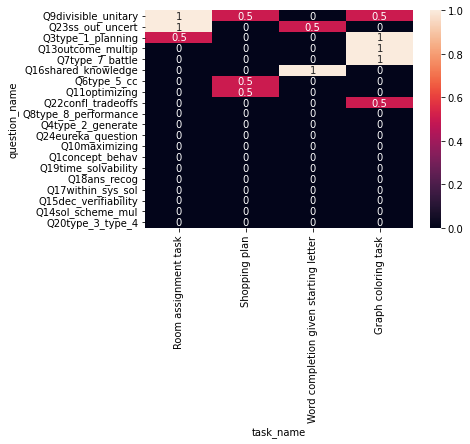

In [153]:
modal_truth_diff = ground_truth-modal_results
modal_truth_diff = modal_truth_diff.assign(sum=abs(modal_truth_diff).sum(axis=1)).sort_values(by='sum', ascending=False).iloc[:, :-1]
modal_truth_diff = modal_truth_diff[modal_truth_diff.sum(0).sort_values(ascending=False).index]
sns.heatmap(abs(modal_truth_diff), annot=True, vmin = 0, vmax = 1)

In [154]:
np.sum(abs(modal_truth_diff))

task_name
Room assignment task                     2.5
Shopping plan                            1.5
Word completion given starting letter    1.5
Graph coloring task                      4.0
dtype: float64

<AxesSubplot:xlabel='task_name', ylabel='question_name'>

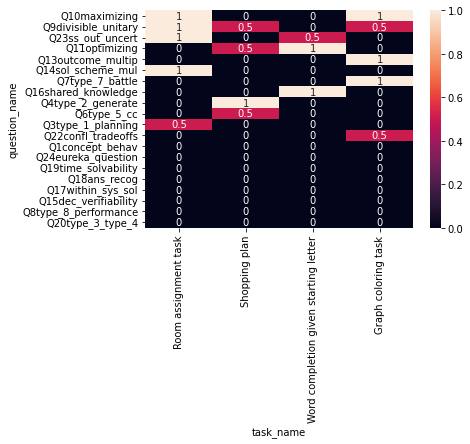

In [155]:
karger_truth_diff = ground_truth-karger_results_with_limited_labels
karger_truth_diff = karger_truth_diff.assign(sum=abs(karger_truth_diff).sum(axis=1)).sort_values(by='sum', ascending=False).iloc[:, :-1]
karger_truth_diff = karger_truth_diff[karger_truth_diff.sum(0).sort_values(ascending=False).index]
sns.heatmap(abs(karger_truth_diff), annot=True, vmin = 0, vmax = 1)

In [156]:
np.sum(abs(karger_truth_diff))

task_name
Room assignment task                     4.5
Shopping plan                            2.5
Word completion given starting letter    2.5
Graph coloring task                      4.0
dtype: float64

## Examine Full Modal v. Karger Results (All Data)

<AxesSubplot:ylabel='question_name'>

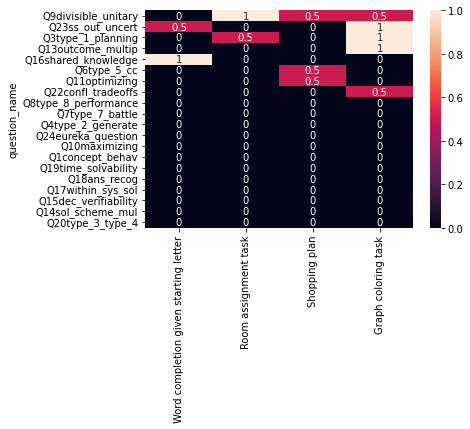

In [67]:
karger_full_results = pd.read_csv('./karger-results.csv').set_index("question_name")

karger_full_truth_diff = ground_truth - karger_full_results
#karger_full_truth_diff
karger_full_truth_diff = karger_full_truth_diff.assign(sum=abs(karger_full_truth_diff).sum(axis=1)).sort_values(by='sum', ascending=False).iloc[:, :-1]
karger_full_truth_diff = karger_full_truth_diff[karger_full_truth_diff.sum(0).sort_values(ascending=False).index]
sns.heatmap(abs(karger_full_truth_diff), annot=True, vmin = 0, vmax = 1)

In [68]:
karger_full_results

,Word completion given starting letter,Graph coloring task,Shopping plan,Room assignment task
question_name,,,,
Q10maximizing,1,0,1,1
Q11optimizing,0,1,1,1
Q13outcome_multip,0,1,1,1
Q14sol_scheme_mul,0,0,0,0
Q15dec_verifiability,1,1,1,1
Q16shared_knowledge,0,1,1,1
Q17within_sys_sol,1,1,1,1
Q18ans_recog,1,1,1,1
Q19time_solvability,1,1,1,1


In [140]:
def get_modal_ratings(df):
  data_mode = df.drop("name", axis =1)
  # currently this is using mode (pd.Series.mode), but can be replaced to aggregate using other functions (e.g., mean, median)
  #data_mode = data_mode.groupby(["question_name", "task_name"], as_index=False).agg(mean) #this version does mean
  data_mode = data_mode.groupby(["question_name", "task_name"], as_index=False).agg(correctedMode) #this version does mode
  data_mode = data_mode.pivot(index = "question_name", columns = "task_name")
  return(data_mode)

In [147]:
modal_full_results = get_modal_ratings(df_karger).replace(-1,0)
modal_full_results.columns = modal_full_results.columns.droplevel(0)
modal_full_results

task_name,Graph coloring task,Room assignment task,Shopping plan,Word completion given starting letter
question_name,,,,
Q10maximizing,0.0,1.0,1.0,1.0
Q11optimizing,1.0,1.0,1.0,0.0
Q13outcome_multip,1.0,1.0,1.0,0.0
Q14sol_scheme_mul,0.0,0.0,0.0,0.0
Q15dec_verifiability,1.0,1.0,1.0,1.0
Q16shared_knowledge,1.0,1.0,1.0,0.0
Q17within_sys_sol,1.0,1.0,1.0,1.0
Q18ans_recog,1.0,1.0,1.0,1.0
Q19time_solvability,1.0,1.0,1.0,1.0


In [148]:
karger_full_results-modal_full_results

,Graph coloring task,Room assignment task,Shopping plan,Word completion given starting letter
question_name,,,,
Q10maximizing,0.0,0.0,0.0,0.0
Q11optimizing,0.0,0.0,0.0,0.0
Q13outcome_multip,0.0,0.0,0.0,0.0
Q14sol_scheme_mul,0.0,0.0,0.0,0.0
Q15dec_verifiability,0.0,0.0,0.0,0.0
Q16shared_knowledge,0.0,0.0,0.0,0.0
Q17within_sys_sol,0.0,0.0,0.0,0.0
Q18ans_recog,0.0,0.0,0.0,0.0
Q19time_solvability,0.0,0.0,0.0,0.0


<AxesSubplot:xlabel='task_name', ylabel='question_name'>

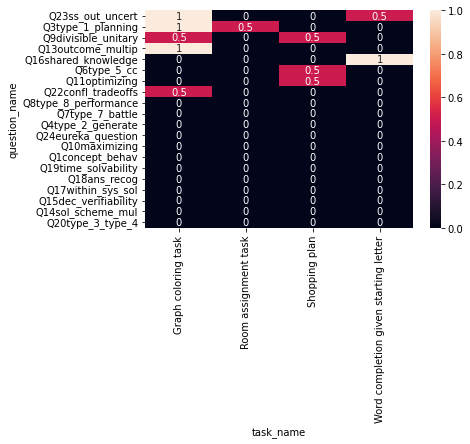

In [149]:
modal_full_truth_diff = modal_full_results-ground_truth
modal_full_truth_diff = modal_full_truth_diff.assign(sum=abs(modal_full_truth_diff).sum(axis=1)).sort_values(by='sum', ascending=False).iloc[:, :-1]
modal_full_truth_diff = modal_full_truth_diff[modal_full_truth_diff.sum(0).sort_values(ascending=False).index]
sns.heatmap(abs(modal_full_truth_diff), annot=True, vmin = 0, vmax = 1)